<a href="https://colab.research.google.com/github/brunaruppruela/mestrado_IFES_IA/blob/main/Trabalho2_IA_VFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Introdução
O problema do Caixeiro Viajante (TSP)  é um dos problemas mais estudados na teoria dos grafos e otimização combinatória. O TSP pode ser descrito da seguinte maneira: dado um conjunto de cidades
e as distancias entre cada par de cidades, o objetivo  ́e encontrar o caminho mais curto que visita cada cidade exatamente uma vez e retorna à cidade de origem. Este problema  ́e de grande relevância em diversas  ́areas, como log ́ıstica, planejamento de rotas e bioinformática [1,5]

## 2 - Algoritmos utilizados

Para resolver o problema do TSP, implementamos e comparamos tres algoritmos diferentes: Hill-Climbing
com reinício, Simulated Annealing e Algoritmo Genético.

### Especificações iniciais

Para os testes nos algoritmos considerou-se a entrada do TSP como um conjunto de pontos representando posições de cidades. A solução é o trajeto mais curto para, partindo de uma cidade inicial, visitar todas as cidades
uma vez e depois retornar à cidade inicial. A Figura 1 exemplifica as soluções para um conjunto dado.

Considere as seguintes definições para resolução do problema:


* **Função Objetivo:** A função objetivo a ser minimizada é o tamanho total do trajeto entre as cidades. A distancia entre duas cidades será obtida através da norma L2.

* **Representação do estado:** Uma solução para o problema será dada por uma sequência de números inteiros representando a ordem em que as cidades serão visitadas. Como cada cidade deve ser visitada apenas uma vez, não devem existir repetições de cidades no estado. A Figura 4 ilustra trajetos e o valor de estado de acordo com a representação proposta.

* **Geração de Vizinhos e Mutação:** A geração de vizinhos e a operação de mutação no algoritmo genético serão dadas pela troca da posição de duas cidades escolhidas aleatoriamente no trajeto. Por exemplo, o estado [2, **4**, 5, **6**, 3] poderia ser transformado em [2, **6**, 5, **4**, 3] trocando as posições das cidades 4 e 6.

* *Crossover*: Para evitar repetições de cidades após esta operação, usaremos um operador de *crossover* especial chamado Order 1 Crossover ou (OX Crossover)
    
    *Justificativa:* a operação de single-point crossover não é adequada para estados representados como permutações de números porque ela pode gerar repetição ou ausência de números (cidades) nos estados filhos. Por exemplo, assuma que os estados pais são p1 = [1, 3, 5, 2, 6, 4] e p2 = [6, 4, 1, 3, 2, 5] e que a posição escolhida para crossover é a posição 1 (assumindo índices que começam de 0). Então, usando o single-point crossover, os filhos seriam c1 = [**1, 3**, 1, 3, 2, 5] e c2 = [6, 4, ** 5, 2, 6, 4** ]. Observe que em c1, as cidades 1 e 3 são visitadas 2 vezes e as cidades 4 e 6 nunca são visitadas. Já em c2, as cidades 4 é visitada 2 vezes e a cidade 5 nunca é visitada.


* **Parâmetros:** O número de iterações assim como o tamanho população (10-30) e o número de gerações (ex: 50-300) do genético devem ser ajustados dependendo do número de cidades. Quanto mais cidades, mais difícil o problema e, portanto, mais chamadas à função objetivo podem ser necessárias.

    *Importante:* para uma comparação justa, garanta que todos os algoritmos façam um
    mesmo número de chamadas à função objetivo. Teste diferentes número de restarts até encontrar um que leve a bons resultados no [HC-R] (Hill-Climbing with Restart). Para o [SA] (Simulated Annealing), defina a temperatura inicialmente como 1000 com fator de redução (ex: 0.99-0.9999) de forma a chegar próxima a 0 (zero) após 50-70% das iterações (ex: 2000-4000). Para o algoritmo genético, use probabilidade de mutação entre 10% e 20%.

* **Visualização:** A visualização consiste em apresentar os pontos representando cidades e o trajeto dado pela solução atual.


Figura 1 - As figuras apresentam soluções para o problema do caixeiro viajante (travelling salesman problem – TSP). A
solução (a) tem custo de caminho inferior à solução (b). Observe que o número de cruzamentos de trechos em (b) é
menor que em (a).

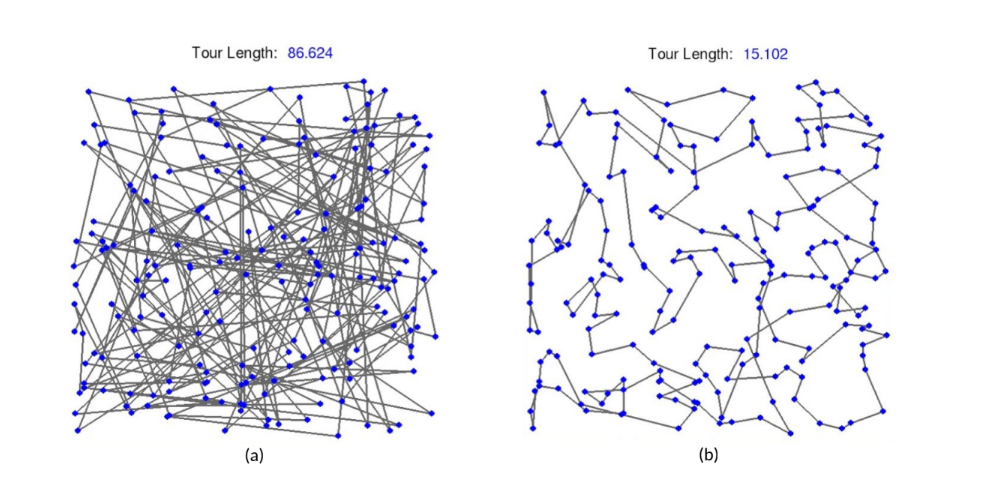

### Funções auxiliares

In [21]:
import numpy as np
import pandas as pd
import random

# Função para gerar coordenadas aleatórias
def gera_coordenadas_aleatorias(n_cidades):
    return pd.DataFrame({
        'X': np.random.randint(0, 100, n_cidades),
        'Y': np.random.randint(0, 100, n_cidades)
    })

# Função para gerar a matriz de distâncias
def gera_problema_tsp(df_coordenadas):
    n_cidades = len(df_coordenadas)
    tsp = np.zeros((n_cidades, n_cidades))
    for i in range(n_cidades):
        for j in range(i + 1, n_cidades):
            dist = np.linalg.norm(df_coordenadas.iloc[i] - df_coordenadas.iloc[j])
            tsp[i, j] = dist
            tsp[j, i] = dist
    return pd.DataFrame(tsp)

# Função para calcular a distância total do caminho
def total_distance(path, tsp):
    total = 0
    for i in range(len(path) - 1):
        total += tsp.iloc[path[i], path[i + 1]]
    total += tsp.iloc[path[-1], path[0]]
    return total

# Plota a solução do roteamento das cidades
# usando a biblioteca PLOTLY
def plota_rotas(df_cidades, ordem_cidades):
    df_solucao = df_cidades.copy()
    df_solucao = df_solucao.reindex(ordem_cidades)

    X = df_solucao['X']
    Y = df_solucao['Y']
    cidades = list(df_solucao.index)

    # cria objeto gráfico
    fig = go.Figure()

    fig.update_layout(autosize=False, width=500, height=500, showlegend=False)

    # gera linhas com as rotas da primeira ate a ultima cidade
    fig.add_trace(go.Scatter(x=X, y=Y,
                             text=cidades, textposition='bottom center',
                             mode='lines+markers+text',
                             name=''))

    # acrescenta linha da última para a primeira para fechar o ciclo
    fig.add_trace(go.Scatter(x=X.iloc[[-1,0]], y=Y.iloc[[-1,0]],
                             mode='lines+markers', name=''))

    fig.show()


def boxplot_sorted(df, rot=90, figsize=(12,6), fontsize=20):
    df2 = df.T
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, fontsize=fontsize,
                                   boxprops=dict(linewidth=4, color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, color='firebrick'),
                                   capprops=dict(linewidth=4, color='cornflowerblue'),
                                   flierprops=dict(marker='o', markerfacecolor='dimgray',
                                        markersize=12, markeredgecolor='black'),
                                   return_type="axes")

    axes.set_title("Cost of Algorithms", fontsize=fontsize)

# Função para gerar coordenadas aleatórias
def gera_coordenadas_aleatorias(n_cidades):
    return pd.DataFrame({
        'X': np.random.randint(0, 100, n_cidades),
        'Y': np.random.randint(0, 100, n_cidades)
    })

# Função para gerar a matriz de distâncias
def gera_problema_tsp(df_coordenadas):
    n_cidades = len(df_coordenadas)
    tsp = np.zeros((n_cidades, n_cidades))
    for i in range(n_cidades):
        for j in range(i + 1, n_cidades):
            dist = np.linalg.norm(df_coordenadas.iloc[i] - df_coordenadas.iloc[j])
            tsp[i, j] = dist
            tsp[j, i] = dist
    return pd.DataFrame(tsp)

# Função para calcular a distância total do caminho
def total_distance(path, tsp):
    total = 0
    for i in range(len(path) - 1):
        total += tsp.iloc[path[i], path[i + 1]]
    total += tsp.iloc[path[-1], path[0]]
    return total

### Hill-Climbing com Reinício
O algoritmo Hill-Climbing  é uma técnica de busca local que começa com uma solu ̧cão inicial e tenta melhorar iterativamente, trocando a solução atual por uma solução vizinha melhor. O algoritmo pode ficar preso em  ́ótimos locais, então utilizamos a estratégia de reínicio aleatório multiplas vezes para
aumentar a probabilidade de encontrar o ótimo global [6].

In [22]:
# Hill-Climbing com Restart
def hill_climbing_restart(tsp, max_restarts=10):

    def hill_climbing(tsp):

        current_path = random.sample(range(len(tsp)), len(tsp))
        current_distance = total_distance(current_path, tsp)
        improving = True

        while improving:
            improving = False
            for i in range(len(current_path)):
                for j in range(i + 1, len(current_path)):
                    new_path = current_path[:]
                    new_path[i:j+1] = reversed(new_path[i:j+1])
                    new_distance = total_distance(new_path, tsp)
                    if new_distance < current_distance:
                        current_path = new_path
                        current_distance = new_distance
                        improving = True
        return current_distance, current_path

    best_distance = float('inf')
    best_path = None
    for _ in range(max_restarts):
        distance, path = hill_climbing(tsp)
        if distance < best_distance:
            best_distance = distance
            best_path = path
    return best_distance, best_path

In [23]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Geração de números aleatórios
import random

# Geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [24]:
# busca local da melhor solução e o seu custo
custo, solucao = hill_climbing_restart(tsp)

print(f'{custo:7.3f}    {solucao}')

plota_rotas(df_coordenadas, solucao)

247.776    [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]


In [ ]:
# busca local da melhor solução e o seu custo várias vezes
for _ in range(10):
    custo, solucao = hill_climbing_restart(tsp)

    print(f'{custo:7.3f}    {solucao}')

    plota_rotas(df_coordenadas, solucao)

### Simulated Annealing

O algoritmo Simulated Annealing é inspirado no processo de recozimento em metalurgia. Ele permite movimentos para soluções piores com uma certa probabilidade que diminui ao longo do tempo, o que ajuda
a escapar de ótimos locais. A temperatura inicial e a taxa de resfriamento são parametros importantes
que controlam o comportamento do algoritmo [4, 7].

In [ ]:
import numpy as np
import math
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Funções para plotar os gráficos
def plot_path(cities_xy, cities_path, ax):
    cities = cities_xy[cities_path]
    x = cities[:, 0]
    y = cities[:, 1]

    ax.set_xlabel('X (Longitude)')
    ax.set_ylabel('Y (Latitude)')
    ax.set_title('Caminho')

    ax.plot(x, y, color='blue', linestyle='-', linewidth=2)
    ax.plot(x, y, color='red', marker='o', markersize=8, linestyle='')
    ax.plot(x[[-1, 0]], y[[-1, 0]], color='orange', linestyle='-', linewidth=2)

def plot_distances(iteration_list, distance_list, best_distances, ax):
    x = iteration_list
    y1 = distance_list
    y2 = best_distances

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Distâncias (custos)')
    ax.set_title('Comprimento Total do caminho')

    ax.plot(x, y1, label='Atual')
    ax.plot(x, y2, label='Melhor')
    ax.legend()

def plot_acceptance_prob(iteration_list, accept_p_list, ax):
    x = iteration_list
    y = accept_p_list

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    xc, yc, colors = zip(*[(xi, yi, 'b') if yi == 1.0 else (xi, yi, 'r') for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

def plot_temperature(iteration_list, temperat_list, ax):
    x = iteration_list
    y = temperat_list

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.set_ylim([0, 1000])

    ax.plot(x, y)

def plot_axes_figure(cities_xy, cities_path, iteration_list, distance_list, best_distances, accept_p_list, temperat_list):
    clear_output(wait=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    plot_path(cities_xy, cities_path, ax1)
    plot_distances(iteration_list, distance_list, best_distances, ax2)
    plot_acceptance_prob(iteration_list, accept_p_list, ax3)
    plot_temperature(iteration_list, temperat_list, ax4)

    fig.tight_layout()
    plt.pause(0.001)

# Funções auxiliares para o algoritmo
def calculate_distance(city_a, city_b):
    return np.linalg.norm(city_a - city_b)

def total_distance(route, distance_matrix):
    total = 0
    for i in range(len(route) - 1):
        city_a = route[i]
        city_b = route[i + 1]
        total += distance_matrix[city_a, city_b]
    total += distance_matrix[route[-1], route[0]]
    return total

def generate_neighbor(route):
    new_route = route.copy()
    index_a = random.randint(0, len(route) - 1)
    index_b = random.randint(0, len(route) - 1)
    new_route[index_a], new_route[index_b] = new_route[index_b], new_route[index_a]
    return new_route

def acceptance_probability(current_distance, new_distance, temperature):
    if new_distance < current_distance:
        return 1.0
    else:
        return math.exp((current_distance - new_distance) / temperature)

# Função Simulated Annealing
def simulated_annealing(tsp, initial_temperature=1000, cooling_rate=0.995, iterations=2000, nrep=50):
    cities = tsp.values
    num_cities = len(cities)
    distance_matrix = tsp.values

    current_route = np.arange(num_cities)
    best_route = current_route.copy()

    current_distance = total_distance(current_route, distance_matrix)
    best_distance = current_distance

    temperature = initial_temperature

    iteration_list = []
    best_distances = []
    distance_list = []
    accept_p_list = []
    temperat_list = []

    for iteration in range(iterations):
        for _ in range(nrep):
            new_route = generate_neighbor(current_route)
            new_distance = total_distance(new_route, distance_matrix)
            acceptance_prob = acceptance_probability(current_distance, new_distance, temperature)
            if random.random() < acceptance_prob:
                current_route = new_route
                current_distance = new_distance

        temperature *= cooling_rate

        if current_distance < best_distance:
            best_route = current_route
            best_distance = current_distance

        iteration_list.append(iteration)
        best_distances.append(best_distance)
        distance_list.append(current_distance)
        accept_p_list.append(acceptance_prob)
        temperat_list.append(temperature)

        if iteration % 50 == 0:
            plot_axes_figure(cities, current_route, iteration_list, distance_list, best_distances, accept_p_list, temperat_list)

    return best_distance, best_route


Testando o SA

In [ ]:
def main():
    n_cidades = 10
    df_coordenadas = gera_coordenadas_aleatorias(n_cidades)
    tsp = gera_problema_tsp(df_coordenadas)

    initial_temperature = 1000.0
    cooling_rate = 0.995
    iterations = 2000

    best_distance, best_route = simulated_annealing(tsp, initial_temperature, cooling_rate, iterations)

    print("Melhor distância:", best_distance)
    print("Melhor caminho:", best_route)

    # Plota a melhor rota
    plota_rotas(df_coordenadas, best_route)

if __name__ == '__main__':
    main()

### Algoritmo Genético

O Algoritmo Genético é inspirado nos processos de evolução natural. Ele mantém , utilizando operadores como sele ̧c ̃ao, crossover e muta ̧c ̃ao puma população de soluções para gerar novas soluçoes. Ao longo de
várias gerações, as soluções tendem a melhorar, convergindo para um ótimo global ou próximo dele [2,3].

In [ ]:
# Função de mutação
def mutate(path):
    index1, index2 = sorted(random.sample(range(len(path)), 2))
    path[index1:index2+1] = reversed(path[index1:index2+1])
    return path

# Função para inicializar a população
def initialize_population(num_cities, population_size):
    population = []
    for _ in range(population_size):
        population.append(random.sample(range(num_cities), num_cities))
    return population

# Função de seleção de pais por torneio
def select_parents(population, tsp):
    tournament_size = 3
    selected_parents = []
    for _ in range(2):
        tournament = random.sample(population, tournament_size)
        best_path = min(tournament, key=lambda x: total_distance(x, tsp))
        selected_parents.append(best_path)
    return selected_parents

# Função de crossover
def crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))

    # Copia uma parte do pai 1 para o filho
    child[start:end] = parent1[start:end]

    # Copia as cidades restantes do pai 2 na ordem em que aparecem,
    # ignorando as que já estão no filho
    current_position = end
    for i in range(end, size + end):
        if parent2[i % size] not in child:
            child[current_position % size] = parent2[i % size]
            current_position += 1

    return child

In [ ]:
# Algoritmo genético
def genetic_algorithm(tsp, population_size=30, generations=300):
    num_cities = len(tsp)
    population = initialize_population(num_cities, population_size)

    for _ in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, tsp)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        population = new_population

    best_path = min(population, key=lambda x: total_distance(x, tsp))
    best_distance = total_distance(best_path, tsp)

    return best_distance, best_path

In [ ]:
# busca local da melhor solução e o seu custo com GA
custo, solucao = genetic_algorithm(tsp)

print(f'{custo:7.3f}    {solucao}')

# Plota a melhor rota
plota_rotas(df_coordenadas, solucao)

In [ ]:
# busca local da melhor solução e o seu custo com GA várias vezes
for _ in range(10):
    custo, solucao = genetic_algorithm(tsp)

    print(f'{custo:7.3f}    {solucao}')

    plota_rotas(df_coordenadas, solucao)

# Resultados

Executamos cada algoritmo várias vezes para gerar estatisticas sobre os custos das soluções encontradas.
A seguir, apresentamos uma compilação das funções de cada algoritmo e os resultados obtidos.

In [9]:
import numpy as np
import pandas as pd
import random

# Função para gerar coordenadas aleatórias
def gera_coordenadas_aleatorias(n_cidades):
    return pd.DataFrame({
        'X': np.random.randint(0, 100, n_cidades),
        'Y': np.random.randint(0, 100, n_cidades)
    })

# Função para gerar a matriz de distâncias
def gera_problema_tsp(df_coordenadas):
    n_cidades = len(df_coordenadas)
    tsp = np.zeros((n_cidades, n_cidades))
    for i in range(n_cidades):
        for j in range(i + 1, n_cidades):
            dist = np.linalg.norm(df_coordenadas.iloc[i] - df_coordenadas.iloc[j])
            tsp[i, j] = dist
            tsp[j, i] = dist
    return pd.DataFrame(tsp)

# Função para calcular a distância total do caminho
def total_distance(path, tsp):
    total = 0
    for i in range(len(path) - 1):
        total += tsp.iloc[path[i], path[i + 1]]
    total += tsp.iloc[path[-1], path[0]]
    return total

# Função de mutação
def mutate(path):
    index1, index2 = sorted(random.sample(range(len(path)), 2))
    path[index1:index2+1] = reversed(path[index1:index2+1])
    return path

# Função para inicializar a população
def initialize_population(num_cities, population_size):
    population = []
    for _ in range(population_size):
        population.append(random.sample(range(num_cities), num_cities))
    return population

# Função de seleção de pais por torneio
def select_parents(population, tsp):
    tournament_size = 3
    selected_parents = []
    for _ in range(2):
        tournament = random.sample(population, tournament_size)
        best_path = min(tournament, key=lambda x: total_distance(x, tsp))
        selected_parents.append(best_path)
    return selected_parents

# Função de crossover
def crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))

    # Copia uma parte do pai 1 para o filho
    child[start:end] = parent1[start:end]

    # Copia as cidades restantes do pai 2 na ordem em que aparecem,
    # ignorando as que já estão no filho
    current_position = end
    for i in range(end, size + end):
        if parent2[i % size] not in child:
            child[current_position % size] = parent2[i % size]
            current_position += 1

    return child

# Hill-Climbing com Restart
def hill_climbing_restart(tsp, max_restarts=10):
    def hill_climbing(tsp):
        current_path = random.sample(range(len(tsp)), len(tsp))
        current_distance = total_distance(current_path, tsp)
        improving = True
        while improving:
            improving = False
            for i in range(len(current_path)):
                for j in range(i + 1, len(current_path)):
                    new_path = current_path[:]
                    new_path[i:j+1] = reversed(new_path[i:j+1])
                    new_distance = total_distance(new_path, tsp)
                    if new_distance < current_distance:
                        current_path = new_path
                        current_distance = new_distance
                        improving = True
        return current_distance, current_path

    best_distance = float('inf')
    best_path = None
    for _ in range(max_restarts):
        distance, path = hill_climbing(tsp)
        if distance < best_distance:
            best_distance = distance
            best_path = path
    return best_distance, best_path

# Simulated Annealing
def simulated_annealing(tsp, initial_temp=1000, cooling_rate=0.995, max_iter=2000):
    def probability_acceptance(old_cost, new_cost, temperature):
        if new_cost < old_cost:
            return 1.0
        else:
            return np.exp((old_cost - new_cost) / temperature)

    current_path = random.sample(range(len(tsp)), len(tsp))
    current_distance = total_distance(current_path, tsp)
    best_path = current_path
    best_distance = current_distance
    temperature = initial_temp

    for _ in range(max_iter):
        i, j = sorted(random.sample(range(len(current_path)), 2))
        new_path = current_path[:]
        new_path[i:j+1] = reversed(new_path[i:j+1])
        new_distance = total_distance(new_path, tsp)

        if probability_acceptance(current_distance, new_distance, temperature) > random.random():
            current_path = new_path
            current_distance = new_distance

        if new_distance < best_distance:
            best_distance = new_distance
            best_path = new_path

        temperature *= cooling_rate

    return best_distance, best_path

# Algoritmo genético
def genetic_algorithm(tsp, population_size=30, generations=300):
    num_cities = len(tsp)
    population = initialize_population(num_cities, population_size)

    for _ in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, tsp)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        population = new_population

    best_path = min(population, key=lambda x: total_distance(x, tsp))
    best_distance = total_distance(best_path, tsp)

    return best_distance, best_path

## Executa N vezes Estruturada com DataFrame

A seguir, é apresentada uma forma mais estruturada de se rodar várias vezes usando a estrutura de dados DataFrame para armazenar os resultados e permitir visualização de box-plots

In [10]:
# Cria estrutura de dados (DataFrame) para armazenar vários resultados diferentes e visualizá-los através de estatísticas
def cria_df_custos(algoritmos, n_vezes):
    nomes_algoritmos  = algoritmos.keys()
    n_lin = len(nomes_algoritmos)
    n_col = n_vezes
    df_results = pd.DataFrame(np.zeros((n_lin, n_col)), index=nomes_algoritmos)
    df_results.index.name='ALGORITMO'
    return df_results

# Executa N vezes para gerar estatísticas da variável custo
def executa_n_vezes(tsp, algoritmos, n_vezes):
    # Cria DataFrame para armazenar os resultados
    df_custo = cria_df_custos(algoritmos, n_vezes)

    for algoritmo, funcao_algoritmo in algoritmos.items():
        print(algoritmo)
        for i in range(n_vezes):
            custo, solucao = funcao_algoritmo(tsp)
            df_custo.loc[algoritmo, i] = custo
            print(f'{custo:10.3f}  {solucao}')

    return df_custo

# Dicionário com Nomes dos modelos e suas respectivas variantes
algoritmos = {
    'Hill-Climbing_Restart': hill_climbing_restart,
    'Simulated Annealing': simulated_annealing,
    'Genetic Algorithm': genetic_algorithm
}

In [11]:
###################################
# PROBLEMA GERADO ALEATORIAMENTE  #
###################################

# Cria instância do problema com n cidades
n_cidades = 10
df_coordenadas = gera_coordenadas_aleatorias(n_cidades)
tsp = gera_problema_tsp(df_coordenadas)

# Número de vezes que executará cada algoritmo
n_vezes = 30

# Executa N vezes para gerar estatísticas da variável custo
df_custo = executa_n_vezes(tsp, algoritmos, n_vezes)


Hill-Climbing_Restart
   247.776  [6, 1, 8, 5, 9, 7, 0, 2, 3, 4]
   247.776  [6, 1, 8, 5, 9, 7, 0, 2, 3, 4]
   247.776  [8, 5, 9, 7, 0, 2, 3, 4, 6, 1]
   247.776  [7, 9, 5, 8, 1, 6, 4, 3, 2, 0]
   247.776  [8, 5, 9, 7, 0, 2, 3, 4, 6, 1]
   247.776  [7, 9, 5, 8, 1, 6, 4, 3, 2, 0]
   247.776  [6, 1, 8, 5, 9, 7, 0, 2, 3, 4]
   247.776  [7, 9, 5, 8, 1, 6, 4, 3, 2, 0]
   247.776  [6, 1, 8, 5, 9, 7, 0, 2, 3, 4]
   247.776  [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]
   247.776  [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]
   247.776  [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]
   247.776  [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]
   247.776  [5, 9, 7, 0, 2, 3, 4, 6, 1, 8]
   247.776  [7, 9, 5, 8, 1, 6, 4, 3, 2, 0]
   247.776  [7, 9, 5, 8, 1, 6, 4, 3, 2, 0]
   247.776  [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]
   247.776  [7, 0, 2, 3, 4, 6, 1, 8, 5, 9]
   247.776  [6, 1, 8, 5, 9, 7, 0, 2, 3, 4]
   247.776  [8, 5, 9, 7, 0, 2, 3, 4, 6, 1]
   247.776  [8, 5, 9, 7, 0, 2, 3, 4, 6, 1]
   247.776  [7, 9, 5, 8, 1, 6, 4, 3, 2, 0]
   247.776  [8, 5, 9, 7, 0, 2, 3

### Estatisticas de cada Algoritmo




Figura 2 - Estatisticas

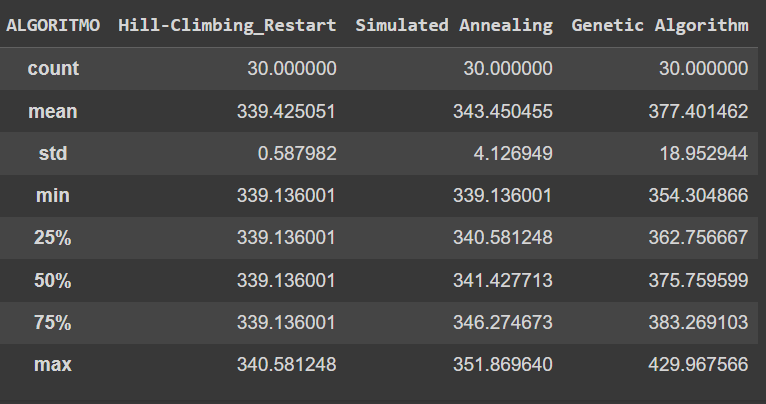

In [12]:
# Estatisticas de cada algoritmo
df_custo.T.describe()


ALGORITMO,Hill-Climbing_Restart,Simulated Annealing,Genetic Algorithm
count,3.000000e+01,30.000000,30.000000
mean,2.477762e+02,247.982727,287.348387
std,8.672276e-14,0.850280,11.419310
min,2.477762e+02,247.776164,251.812493
25%,2.477762e+02,247.776164,280.535972
50%,2.477762e+02,247.776164,289.658411
75%,2.477762e+02,247.776164,293.608241
max,2.477762e+02,252.108654,308.894797


### Blox Splots

In [13]:
# Plota a solução do roteamento das cidades
# usando a biblioteca PLOTLY
def plota_rotas(df_cidades, ordem_cidades):
    df_solucao = df_cidades.copy()
    df_solucao = df_solucao.reindex(ordem_cidades)

    X = df_solucao['X']
    Y = df_solucao['Y']
    cidades = list(df_solucao.index)

    # cria objeto gráfico
    fig = go.Figure()

    fig.update_layout(autosize=False, width=500, height=500, showlegend=False)

    # gera linhas com as rotas da primeira ate a ultima cidade
    fig.add_trace(go.Scatter(x=X, y=Y,
                             text=cidades, textposition='bottom center',
                             mode='lines+markers+text',
                             name=''))

    # acrescenta linha da última para a primeira para fechar o ciclo
    fig.add_trace(go.Scatter(x=X.iloc[[-1,0]], y=Y.iloc[[-1,0]],
                             mode='lines+markers', name=''))

    fig.show()


def boxplot_sorted(df, rot=90, figsize=(12,6), fontsize=20):
    df2 = df.T
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, fontsize=fontsize,
                                   boxprops=dict(linewidth=4, color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, color='firebrick'),
                                   capprops=dict(linewidth=4, color='cornflowerblue'),
                                   flierprops=dict(marker='o', markerfacecolor='dimgray',
                                        markersize=12, markeredgecolor='black'),
                                   return_type="axes")

    axes.set_title("Cost of Algorithms", fontsize=fontsize)

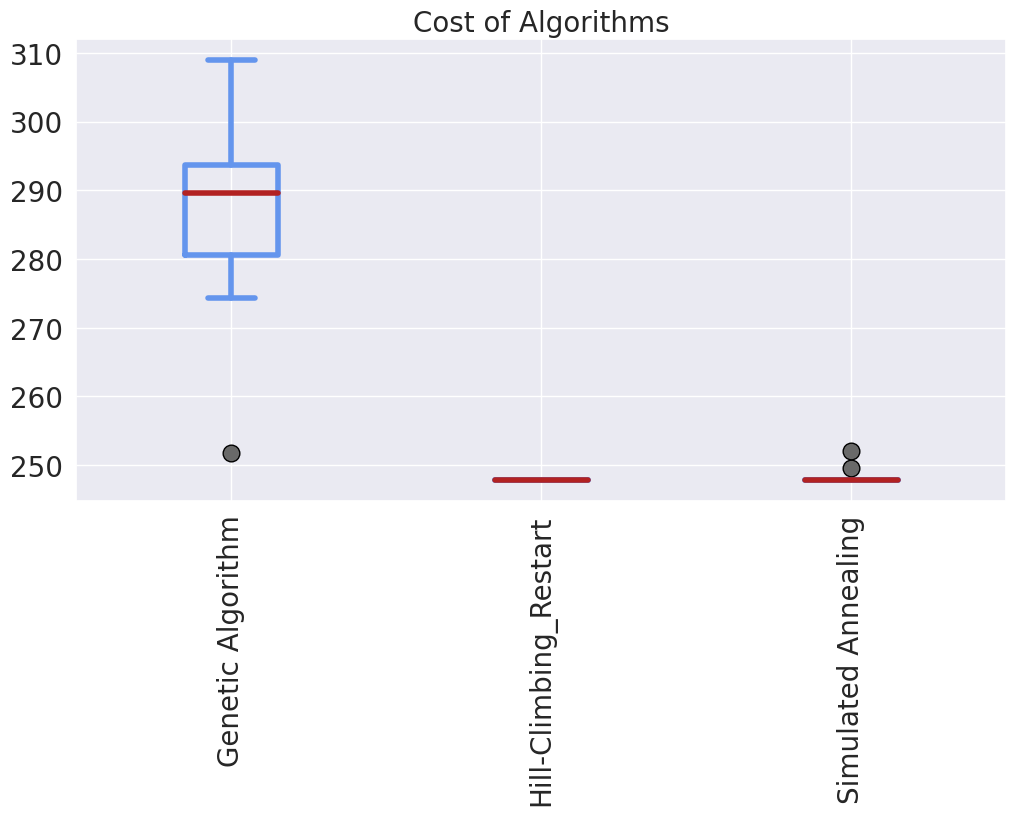

In [14]:
boxplot_sorted(df_custo, rot=90, figsize=(12,6), fontsize=20)

Figura 3 - Plot dos 3 algoritmos

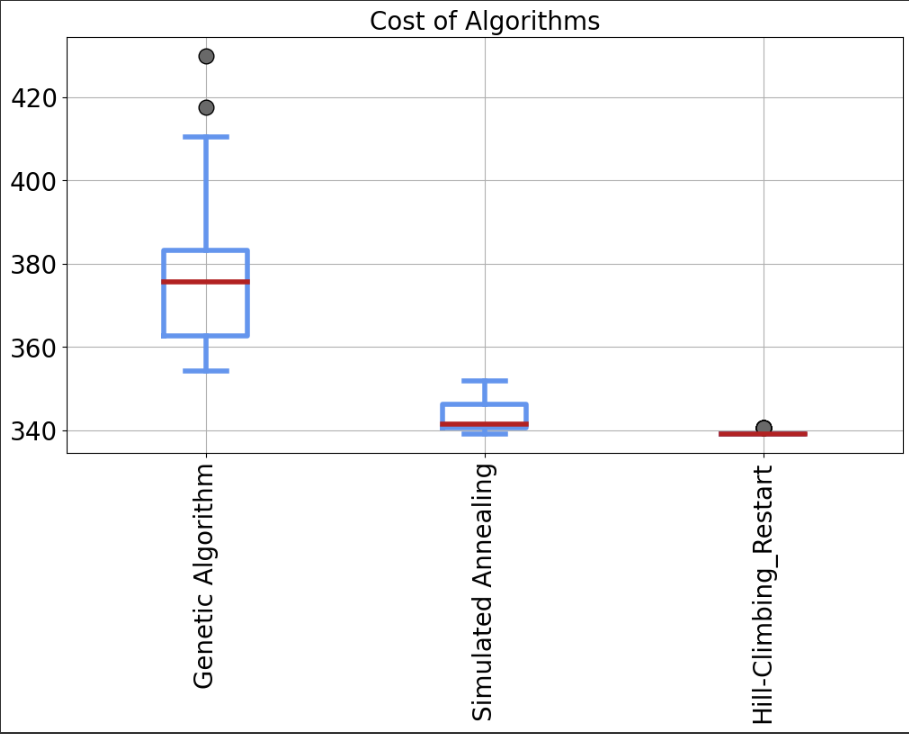

# Discussão

Analisando os resultados, podemos observar que:

* **Hill-Climbing with restart:** Este algoritmo tende a encontrar boas soluções, mas pode ficar preso em  ́otimos locais, mesmo com m ́ultiplos rein ́ıcios. Seu desempenho depende muito do número de reinícios e da qualidade das soluções iniciais [6]

* **Simulated Annealing:** Este algoritmo  ́e eficaz em evitar  ́otimos locais devido `a sua capacidade
de aceitar solu ̧c ̃oes piores com uma certa probabilidade. No entanto, seu desempenho pode variar
bastante dependendo dos parˆametros de temperatura e taxa de resfriamento [4].

* **Algoritmo Gen ́etico:** O Algoritmo Gen ́etico geralmente apresenta os melhores resultados m ́edios,
pois explora um conjunto diversificado de solu ̧c ̃oes e utiliza operadores evolutivos para melhorar
iterativamente.  ́E robusto e menos suscet ́ıvel a ficar preso em  ́otimos locais [2].

Com base nos resultados apresentados, o Algoritmo Gen ́etico se destacou como o mais eficaz na solu ̧c ̃ao do problema do TSP, apresentando o melhor custo m ́edio e uma maior robustez na explora ̧c ̃ao
do espa ̧co de solu ̧c ̃oes

# Conclusão

Neste relat ́orio, discutimos o problema do Caixeiro Viajante e comparamos trˆes algoritmos diferentes
para resolvˆe-lo: Hill-Climbing com Rein ́ıcio, Simulated Annealing e Algoritmo Gen ́etico. Os resultados  mostraram que, embora todos os algoritmos possam encontrar boas solu ̧c ̃oes, o Algoritmo Gen ́etico se destacou como o mais eficaz em termos de custo m ́edio e robustez.

# Referências

[1] David L Applegate, Robert E Bixby, Vasek Chvatal, and William J Cook. The Traveling Salesman Problem: A Computational Study. Princeton University Press, 2006.

[2] David E Goldberg. Genetic Algorithms in Search, Optimization, and Machine Learning. Addison- Wesley, 1989.

[3] John H Holland. Adaptation in Natural and Artificial Systems: An Introductory Analysis with Applications to Biology, Control, and Artificial Intelligence. University of Michigan Press, 1975.

[4] S Kirkpatrick, CD Gelatt, and MP Vecchi. Optimization by simulated annealing. Science,
220(4598):671–680, 1983.

[5] Eugene L Lawler, Jan Karel Lenstra, Alexander H Rinnooy Kan, and David B Shmoys. The Traveling
Salesman Problem: A Guided Tour of Combinatorial Optimization. Wiley, 1985.

[6] Stuart Russell and Peter Norvig. Artificial Intelligence: A Modern Approach. Prentice Hall, 2009.

[7] V ˇCern ́y. Thermodynamical approach to the traveling salesman problem: An efficient simulation
algorithm. Journal of Optimization Theory and Applications, 45(1):41–51, 1985.
3


SANDBOX


# DADOS HC

In [ ]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Geração de números aleatórios
import random

# Geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# busca local da melhor solução e o seu custo
custo, solucao = hill_climbing_restart(tsp)

print(f'{custo:7.3f}    {solucao}')

plota_rotas(df_coordenadas, solucao)

340.581    [0, 1, 2, 7, 9, 3, 8, 4, 6, 5]


In [ ]:
for _ in range(10):
    custo, solucao = hill_climbing_restart(tsp)

    print(f'{custo:7.3f}    {solucao}')

    plota_rotas(df_coordenadas, solucao)

KeyError: (6, 7)

# DADOS SA

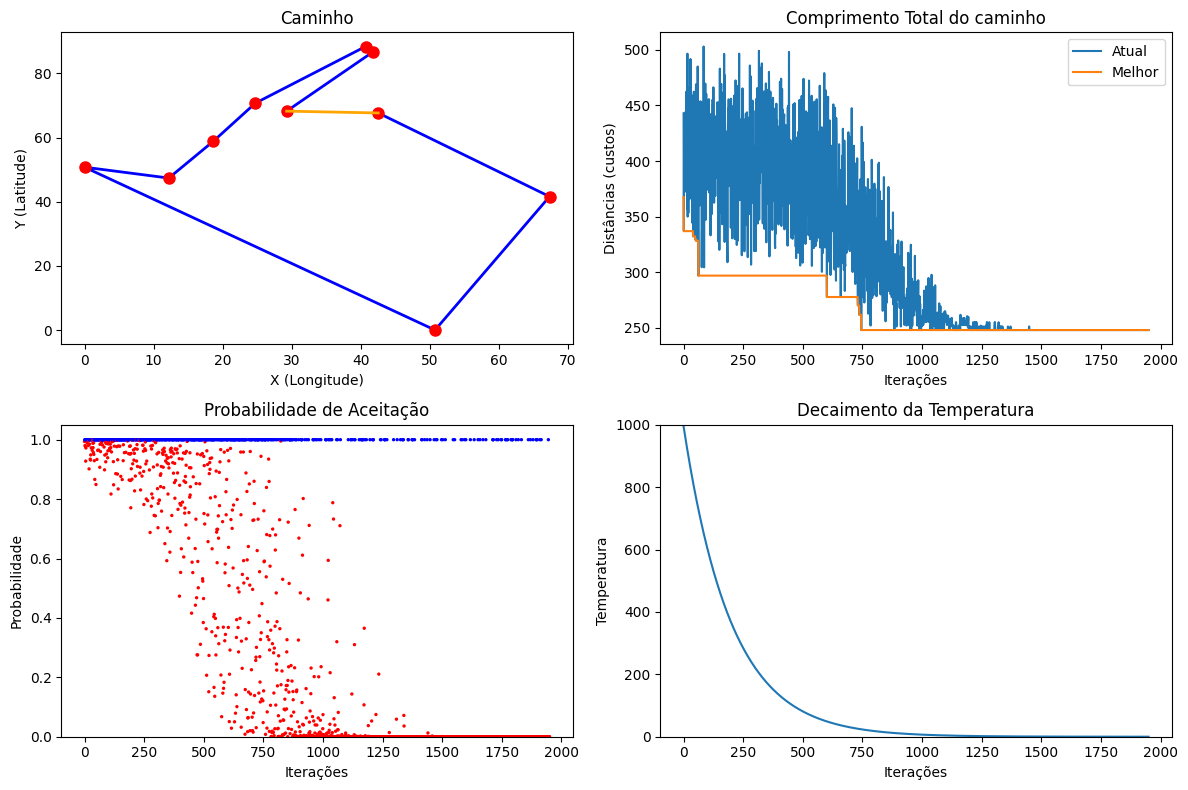

Melhor distância: 248.0878455672241
Melhor caminho: [9 2 3 1 0 8 7 4 6 5]


In [ ]:
import numpy as np
import math
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Funções para plotar os gráficos
def plot_path(cities_xy, cities_path, ax):
    cities = cities_xy[cities_path]
    x = cities[:, 0]
    y = cities[:, 1]

    ax.set_xlabel('X (Longitude)')
    ax.set_ylabel('Y (Latitude)')
    ax.set_title('Caminho')

    ax.plot(x, y, color='blue', linestyle='-', linewidth=2)
    ax.plot(x, y, color='red', marker='o', markersize=8, linestyle='')
    ax.plot(x[[-1, 0]], y[[-1, 0]], color='orange', linestyle='-', linewidth=2)

def plot_distances(iteration_list, distance_list, best_distances, ax):
    x = iteration_list
    y1 = distance_list
    y2 = best_distances

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Distâncias (custos)')
    ax.set_title('Comprimento Total do caminho')

    ax.plot(x, y1, label='Atual')
    ax.plot(x, y2, label='Melhor')
    ax.legend()

def plot_acceptance_prob(iteration_list, accept_p_list, ax):
    x = iteration_list
    y = accept_p_list

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    xc, yc, colors = zip(*[(xi, yi, 'b') if yi == 1.0 else (xi, yi, 'r') for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

def plot_temperature(iteration_list, temperat_list, ax):
    x = iteration_list
    y = temperat_list

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.set_ylim([0, 1000])

    ax.plot(x, y)

def plot_axes_figure(cities_xy, cities_path, iteration_list, distance_list, best_distances, accept_p_list, temperat_list):
    clear_output(wait=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    plot_path(cities_xy, cities_path, ax1)
    plot_distances(iteration_list, distance_list, best_distances, ax2)
    plot_acceptance_prob(iteration_list, accept_p_list, ax3)
    plot_temperature(iteration_list, temperat_list, ax4)

    fig.tight_layout()
    plt.pause(0.001)

# Funções auxiliares para o algoritmo
def calculate_distance(city_a, city_b):
    return np.linalg.norm(city_a - city_b)

def total_distance(route, distance_matrix):
    total = 0
    for i in range(len(route) - 1):
        city_a = route[i]
        city_b = route[i + 1]
        total += distance_matrix[city_a, city_b]
    total += distance_matrix[route[-1], route[0]]
    return total

def generate_neighbor(route):
    new_route = route.copy()
    index_a = random.randint(0, len(route) - 1)
    index_b = random.randint(0, len(route) - 1)
    new_route[index_a], new_route[index_b] = new_route[index_b], new_route[index_a]
    return new_route

def acceptance_probability(current_distance, new_distance, temperature):
    if new_distance < current_distance:
        return 1.0
    else:
        return math.exp((current_distance - new_distance) / temperature)

# Função Simulated Annealing
def simulated_annealing(tsp, initial_temperature=1000, cooling_rate=0.995, iterations=2000, nrep=50):
    cities = tsp.values
    num_cities = len(cities)
    distance_matrix = tsp.values

    current_route = np.arange(num_cities)
    best_route = current_route.copy()

    current_distance = total_distance(current_route, distance_matrix)
    best_distance = current_distance

    temperature = initial_temperature

    iteration_list = []
    best_distances = []
    distance_list = []
    accept_p_list = []
    temperat_list = []

    for iteration in range(iterations):
        for _ in range(nrep):
            new_route = generate_neighbor(current_route)
            new_distance = total_distance(new_route, distance_matrix)
            acceptance_prob = acceptance_probability(current_distance, new_distance, temperature)
            if random.random() < acceptance_prob:
                current_route = new_route
                current_distance = new_distance

        temperature *= cooling_rate

        if current_distance < best_distance:
            best_route = current_route
            best_distance = current_distance

        iteration_list.append(iteration)
        best_distances.append(best_distance)
        distance_list.append(current_distance)
        accept_p_list.append(acceptance_prob)
        temperat_list.append(temperature)

        if iteration % 50 == 0:
            plot_axes_figure(cities, current_route, iteration_list, distance_list, best_distances, accept_p_list, temperat_list)

    return best_distance, best_route

def main():
    n_cidades = 10
    df_coordenadas = gera_coordenadas_aleatorias(n_cidades)
    tsp = gera_problema_tsp(df_coordenadas)

    initial_temperature = 1000.0
    cooling_rate = 0.995
    iterations = 2000

    best_distance, best_route = simulated_annealing(tsp, initial_temperature, cooling_rate, iterations)

    print("Melhor distância:", best_distance)
    print("Melhor caminho:", best_route)

    # Plota a melhor rota
    plota_rotas(df_coordenadas, ['A'+str(i) for i in best_route])

if __name__ == '__main__':
    main()


In [ ]:
# busca local da melhor solução e o seu custo com GA
custo, solucao = simulated_annealing(tsp)

print(f'{custo:7.3f}    {solucao}')

# Plota a melhor rota
plota_rotas(df_coordenadas, solucao)

350.966    [8, 6, 4, 2, 1, 0, 5, 7, 9, 3]


# DADOS GA

In [ ]:
# busca local da melhor solução e o seu custo com GA
custo, solucao = genetic_algorithm(tsp)

print(f'{custo:7.3f}    {solucao}')

# Plota a melhor rota
plota_rotas(df_coordenadas, solucao)

346.318    [4, 8, 3, 7, 9, 2, 1, 0, 5, 6]


In [ ]:
for _ in range(2):
    custo, solucao = genetic_algorithm(tsp)

    print(f'{custo:7.3f}    {solucao}')

    plota_rotas(df_coordenadas, solucao)

365.080    [6, 8, 4, 2, 1, 9, 3, 7, 0, 5]


365.057    [9, 3, 8, 6, 4, 0, 5, 2, 1, 7]


Hill-Climbing_Restart
Execução 1 - Melhor Custo Final:    300.018
Execução 2 - Melhor Custo Final:    300.018
Execução 3 - Melhor Custo Final:    296.207
Execução 4 - Melhor Custo Final:    296.207
Execução 5 - Melhor Custo Final:    296.207
Execução 6 - Melhor Custo Final:    300.018
Execução 7 - Melhor Custo Final:    296.207
Execução 8 - Melhor Custo Final:    296.207
Execução 9 - Melhor Custo Final:    300.018
Execução 10 - Melhor Custo Final:    300.018
Simulated Annealing
Execução 1 - Melhor Custo Final:    300.954
Execução 2 - Melhor Custo Final:    300.954
Execução 3 - Melhor Custo Final:    299.188
Execução 4 - Melhor Custo Final:    300.018
Execução 5 - Melhor Custo Final:    296.207
Execução 6 - Melhor Custo Final:    296.207
Execução 7 - Melhor Custo Final:    300.264
Execução 8 - Melhor Custo Final:    296.207
Execução 9 - Melhor Custo Final:    307.436
Execução 10 - Melhor Custo Final:    300.018
Genetic Algorithm
Execução 1 - Melhor Custo Final:    296.207
Execução 2 - M

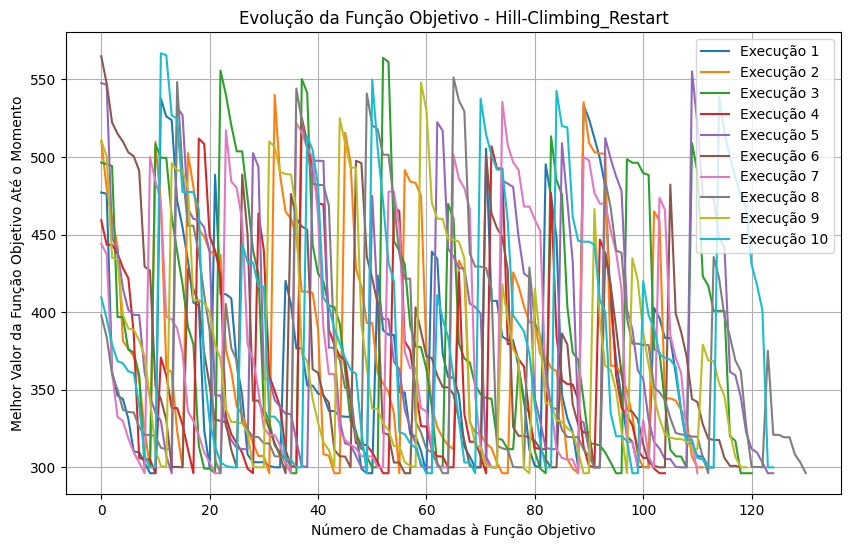

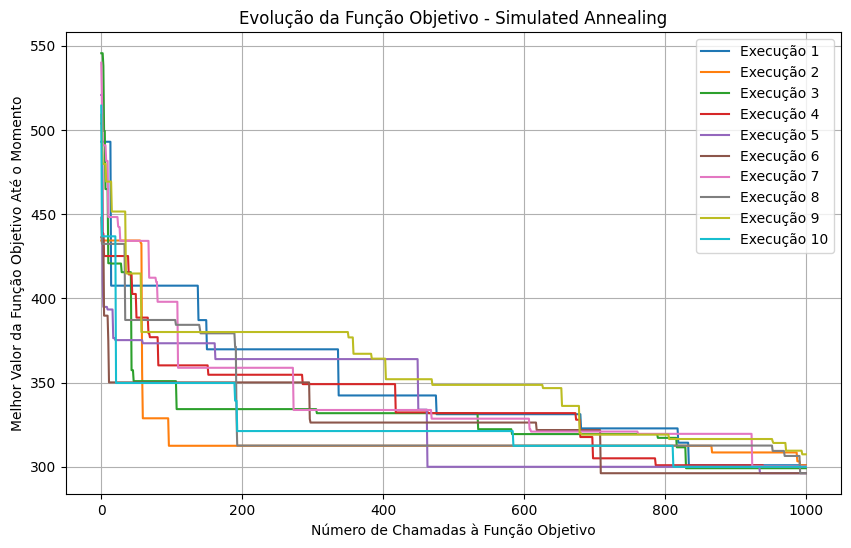

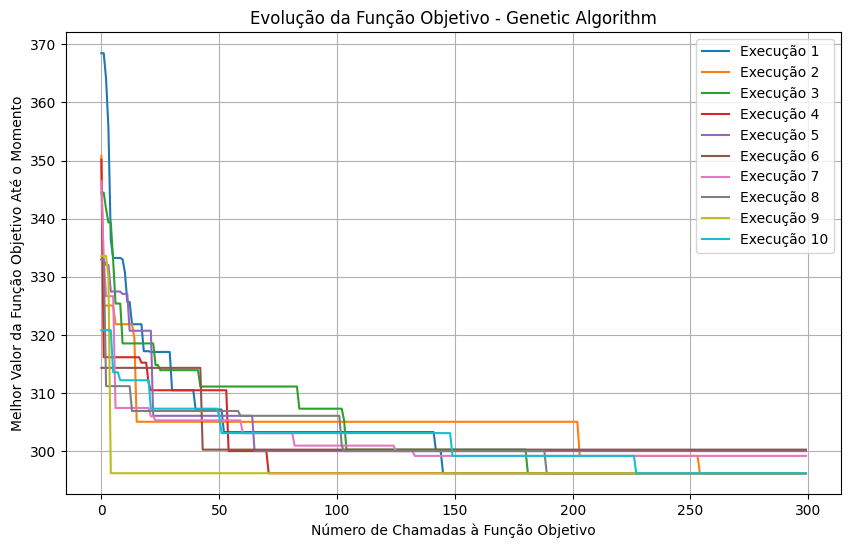

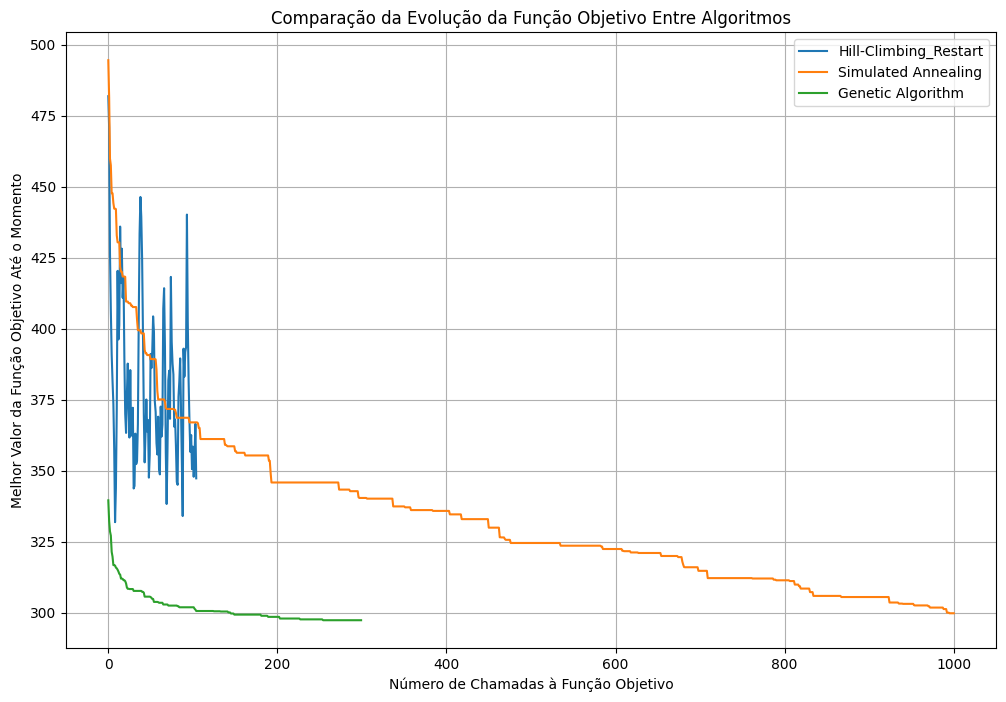

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Função para gerar coordenadas aleatórias
def gera_coordenadas_aleatorias(n_cidades):
    return pd.DataFrame({
        'X': np.random.randint(0, 100, n_cidades),
        'Y': np.random.randint(0, 100, n_cidades)
    })

# Função para gerar a matriz de distâncias
def gera_problema_tsp(df_coordenadas):
    n_cidades = len(df_coordenadas)
    tsp = np.zeros((n_cidades, n_cidades))
    for i in range(n_cidades):
        for j in range(i + 1, n_cidades):
            dist = np.linalg.norm(df_coordenadas.iloc[i] - df_coordenadas.iloc[j])
            tsp[i, j] = dist
            tsp[j, i] = dist
    return pd.DataFrame(tsp)

# Função para calcular a distância total do caminho
def total_distance(path, tsp):
    total = 0
    for i in range(len(path) - 1):
        total += tsp.iloc[path[i], path[i + 1]]
    total += tsp.iloc[path[-1], path[0]]
    return total

# Função de mutação
def mutate(path):
    index1, index2 = sorted(random.sample(range(len(path)), 2))
    path[index1:index2+1] = reversed(path[index1:index2+1])
    return path

# Função para inicializar a população
def initialize_population(num_cities, population_size):
    population = []
    for _ in range(population_size):
        population.append(random.sample(range(num_cities), num_cities))
    return population

# Função de seleção de pais por torneio
def select_parents(population, tsp):
    tournament_size = 3
    selected_parents = []
    for _ in range(2):
        tournament = random.sample(population, tournament_size)
        best_path = min(tournament, key=lambda x: total_distance(x, tsp))
        selected_parents.append(best_path)
    return selected_parents

# Função de crossover
def crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))

    # Copia uma parte do pai 1 para o filho
    child[start:end] = parent1[start:end]

    # Copia as cidades restantes do pai 2 na ordem em que aparecem,
    # ignorando as que já estão no filho
    current_position = end
    for i in range(end, size + end):
        if parent2[i % size] not in child:
            child[current_position % size] = parent2[i % size]
            current_position += 1

    return child

# Hill-Climbing com Restart
def hill_climbing_restart(tsp, max_restarts=10):
    def hill_climbing(tsp):
        current_path = random.sample(range(len(tsp)), len(tsp))
        current_distance = total_distance(current_path, tsp)
        best_distance = current_distance
        iteration_results = [best_distance]
        improving = True
        while improving:
            improving = False
            for i in range(len(current_path)):
                for j in range(i + 1, len(current_path)):
                    new_path = current_path[:]
                    new_path[i:j+1] = reversed(new_path[i:j+1])
                    new_distance = total_distance(new_path, tsp)
                    if new_distance < best_distance:
                        current_path = new_path
                        best_distance = new_distance
                        iteration_results.append(best_distance)
                        improving = True
        return iteration_results

    all_iterations = []
    for _ in range(max_restarts):
        iteration_results = hill_climbing(tsp)
        all_iterations.extend(iteration_results)
    return all_iterations

# Simulated Annealing
def simulated_annealing(tsp, initial_temp=1000, cooling_rate=0.995, max_iter=1000):
    def probability_acceptance(old_cost, new_cost, temperature):
        if new_cost < old_cost:
            return 1.0
        else:
            return np.exp((old_cost - new_cost) / temperature)

    current_path = random.sample(range(len(tsp)), len(tsp))
    current_distance = total_distance(current_path, tsp)
    best_path = current_path
    best_distance = current_distance
    temperature = initial_temp

    iteration_results = [best_distance]

    for _ in range(max_iter):
        i, j = sorted(random.sample(range(len(current_path)), 2))
        new_path = current_path[:]
        new_path[i:j+1] = reversed(new_path[i:j+1])
        new_distance = total_distance(new_path, tsp)

        if probability_acceptance(current_distance, new_distance, temperature) > random.random():
            current_path = new_path
            current_distance = new_distance

        if new_distance < best_distance:
            best_distance = new_distance
            best_path = new_path

        temperature *= cooling_rate
        iteration_results.append(best_distance)

    return iteration_results

# Algoritmo genético
def genetic_algorithm(tsp, population_size=30, generations=300):
    num_cities = len(tsp)
    population = initialize_population(num_cities, population_size)

    iteration_results = []

    best_distance = float('inf')

    for _ in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, tsp)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        population = new_population

        current_best_path = min(population, key=lambda x: total_distance(x, tsp))
        current_best_distance = total_distance(current_best_path, tsp)
        best_distance = min(best_distance, current_best_distance)
        iteration_results.append(best_distance)

    return iteration_results

# Executa N vezes para gerar estatísticas da variável custo
def executa_n_vezes(tsp, algoritmos, n_vezes):
    resultados_evolucao = {algoritmo: [] for algoritmo in algoritmos.keys()}

    for algoritmo, funcao_algoritmo in algoritmos.items():
        print(algoritmo)
        for i in range(n_vezes):
            evolucao = funcao_algoritmo(tsp)
            resultados_evolucao[algoritmo].append(evolucao)
            print(f'Execução {i + 1} - Melhor Custo Final: {evolucao[-1]:10.3f}')

    return resultados_evolucao

# Função para plotar a evolução da função objetivo
def plot_evolution(resultados_evolucao, title):
    plt.figure(figsize=(10, 6))
    for exec_num, evolucao in enumerate(resultados_evolucao, 1):
        plt.plot(evolucao, label=f'Execução {exec_num}')
    plt.xlabel('Número de Chamadas à Função Objetivo')
    plt.ylabel('Melhor Valor da Função Objetivo Até o Momento')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Função para calcular a média das execuções
def calcula_media_evolucao(resultados_evolucao):
    media_evolucao = {}
    for algoritmo, evolucoes in resultados_evolucao.items():
        # Encontrar o comprimento mínimo das evoluções para evitar problemas de alinhamento
        min_length = min(len(evolucao) for evolucao in evolucoes)
        evolucoes_cortadas = [evolucao[:min_length] for evolucao in evolucoes]
        media_evolucao[algoritmo] = np.mean(evolucoes_cortadas, axis=0)
    return media_evolucao

# Função para plotar a comparação da evolução da função objetivo entre os algoritmos
def plot_comparison(media_evolucao):
    plt.figure(figsize=(12, 8))
    for algoritmo, evolucao in media_evolucao.items():
        plt.plot(evolucao, label=f'{algoritmo}')
    plt.xlabel('Número de Chamadas à Função Objetivo')
    plt.ylabel('Melhor Valor da Função Objetivo Até o Momento')
    plt.title('Comparação da Evolução da Função Objetivo Entre Algoritmos')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Dicionário com Nomes dos modelos e suas respectivas variantes
algoritmos = {
    'Hill-Climbing_Restart': hill_climbing_restart,
    'Simulated Annealing': simulated_annealing,
    'Genetic Algorithm': genetic_algorithm
}

###################################
# PROBLEMA GERADO ALEATORIAMENTE  #
###################################

# Cria instância do problema com n cidades
n_cidades = 10
df_coordenadas = gera_coordenadas_aleatorias(n_cidades)
tsp = gera_problema_tsp(df_coordenadas)

# Número de vezes que executará cada algoritmo
n_vezes = 10

# Executa N vezes para gerar estatísticas da variável custo
resultados_evolucao = executa_n_vezes(tsp, algoritmos, n_vezes)

# Plotando a evolução da função objetivo para cada execução de cada algoritmo
for algoritmo, evolucoes in resultados_evolucao.items():
    plot_evolution(evolucoes, f'Evolução da Função Objetivo - {algoritmo}')

# Calculando a média da evolução da função objetivo para cada algoritmo
media_evolucao = calcula_media_evolucao(resultados_evolucao)

# Plotando a comparação da média da evolução da função objetivo entre os algoritmos
plot_comparison(media_evolucao)
